In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

<h3>data analysis<h3>

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '1.png',
 'image_manipulation.ipynb',
 'image_rewrite.ipynb',
 'image_rotate.ipynb',
 'models',
 'models_e',
 'models_r',
 'pictures',
 'pictures_r',
 'rps_cnn.ipynb',
 'rps_cnn_edge_rec.ipynb',
 'rps_cnn_predictor.ipynb',
 'rps_cnn_predictor_edge_rec.ipynb',
 'rps_cnn_predictor_rotated.ipynb',
 'rps_cnn_rotated.ipynb',
 'test',
 'test_e',
 'test_r',
 'train',
 'train_e',
 'train_r']

In [3]:
os.listdir('test_e')

['paper', 'rock', 'scissors']

In [4]:
os.listdir('train_e')

['paper', 'rock', 'scissors']

In [5]:
rock_dir = 'train_e\\rock\\' + os.listdir('train_e\\rock')[0]

In [6]:
rock_img = imread(rock_dir)

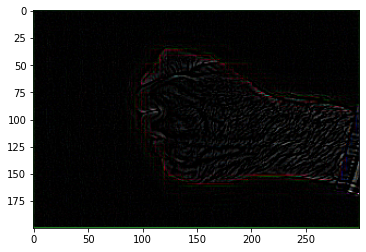

In [7]:
plt.imshow(rock_img)

In [8]:
# rock_img

In [9]:
rock_img.max()

1.0

In [10]:
rock_img.min()

0.0

In [11]:
rock_img.shape

(200, 300, 3)

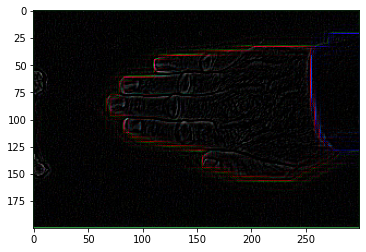

In [12]:
paper_dir = 'train_e\\paper\\' + os.listdir('train_e\\paper')[0]
paper_img = imread(paper_dir)
plt.imshow(paper_img)

In [13]:
paper_img.shape

(200, 300, 3)

In [14]:
len(os.listdir('train_e\\rock'))

626

In [15]:
len(os.listdir('train_e\\paper'))

612

In [16]:
len(os.listdir('train_e\\scissors'))

650

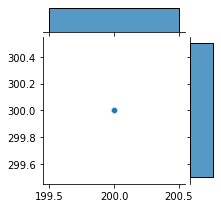

In [17]:
dim1 = []
dim2 = []
for dir1 in ['train_e\\','test_e\\']:
    for dir2 in os.listdir(dir1):
        for img_name in os.listdir(dir1 + dir2): 
            img = imread(dir1 + dir2 + '\\' + img_name)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
sns.jointplot(x=dim1,y=dim2,height=3)

<h3>preparing image generator<h3>

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# help(ImageDataGenerator)

In [20]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
#                                rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='constant',
                               cval=.0
                              )

In [21]:
rock_img[0][0][0]

0.0627451

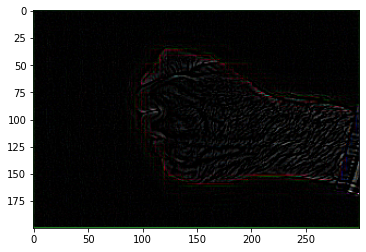

In [22]:
plt.imshow(rock_img)

In [23]:
image_gen.random_transform(rock_img)[0][0][0]

0.0

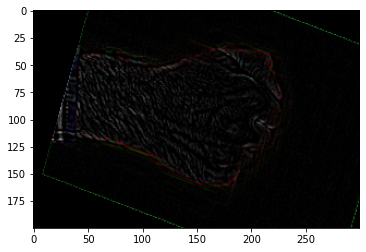

In [24]:
plt.imshow(image_gen.random_transform(rock_img))

In [25]:
image_gen.flow_from_directory('train_e')

Found 1888 images belonging to 3 classes.


In [26]:
image_gen.flow_from_directory('test_e')

Found 300 images belonging to 3 classes.


<h3>creating model<h3>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [28]:
image_shape = (60, 90, 1)

In [29]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 88, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 44, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 42, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 19, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1440)              0

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

<h3>training the model<3>

In [33]:
# help(image_gen.flow_from_directory)

In [34]:
batch_size = 16

In [35]:
train_image_gen = image_gen.flow_from_directory('train',
                                                target_size=image_shape[:2],
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1888 images belonging to 3 classes.


In [36]:
test_image_gen = image_gen.flow_from_directory('test',
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 300 images belonging to 3 classes.


In [37]:
train_image_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [38]:
results = model.fit(train_image_gen,
                    epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/20
118/118 [==============================] - 20s 171ms/step - loss: 1.5191 - accuracy: 0.3882 - val_loss: 0.9742 - val_accuracy: 0.5333
Epoch 2/20
118/118 [==============================] - 21s 179ms/step - loss: 0.8190 - accuracy: 0.6271 - val_loss: 0.7156 - val_accuracy: 0.7000
Epoch 3/20
118/118 [==============================] - 21s 177ms/step - loss: 0.6451 - accuracy: 0.7135 - val_loss: 0.6320 - val_accuracy: 0.7267
Epoch 4/20
118/118 [==============================] - 20s 172ms/step - loss: 0.6113 - accuracy: 0.7436 - val_loss: 0.5604 - val_accuracy: 0.8000
Epoch 5/20
118/118 [==============================] - 20s 169ms/step - loss: 0.5471 - accuracy: 0.7685 - val_loss: 0.5039 - val_accuracy: 0.7933
Epoch 6/20
118/118 [==============================] - 20s 173ms/step - loss: 0.5735 - accuracy: 0.7638 - val_loss: 0.4754 - val_accuracy: 0.8233
Epoch 7/20
118/118 [==============================] - 20s 173ms/step - loss: 0.4517 - accuracy: 0.8326 - val_loss: 0.3954 - val_ac

In [39]:
from datetime import datetime

In [40]:
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save('models_e\\' + timestamp)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models_e\2020-11-07--12-35\assets


<h3>model evaluation<h3>

In [43]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

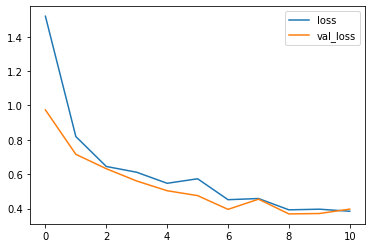

In [44]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

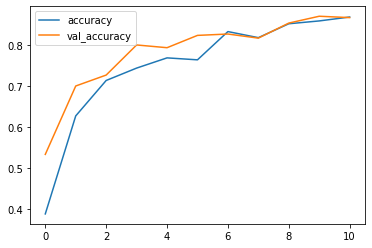

In [45]:
losses[['accuracy','val_accuracy']].plot()

In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.evaluate(test_image_gen)

19/19 [==============================] - 1s 49ms/step - loss: 0.3569 - accuracy: 0.8667


[0.356865257024765, 0.8666666746139526]

In [48]:
pred_probabilities = model.predict(test_image_gen)

In [49]:
pred_probabilities

array([[8.53904724e-01, 1.15585841e-01, 3.05093955e-02],
       [6.72867987e-03, 2.16125736e-05, 9.93249774e-01],
       [1.83046028e-01, 8.12109292e-01, 4.84472653e-03],
       [6.94982588e-01, 2.99405605e-01, 5.61183086e-03],
       [5.25153458e-01, 4.31299396e-03, 4.70533520e-01],
       [8.25410843e-01, 1.63263008e-01, 1.13261417e-02],
       [2.21295744e-01, 6.66976953e-03, 7.72034407e-01],
       [1.84201360e-01, 7.09135413e-01, 1.06663212e-01],
       [7.65506089e-01, 2.21944243e-01, 1.25495875e-02],
       [2.87646115e-01, 7.01098621e-01, 1.12552000e-02],
       [2.06997588e-01, 2.14304682e-02, 7.71571934e-01],
       [9.76276934e-01, 1.82022676e-02, 5.52082201e-03],
       [3.19603235e-01, 8.14569555e-03, 6.72251046e-01],
       [9.88733172e-01, 1.02319187e-02, 1.03487982e-03],
       [9.00568545e-01, 4.94008549e-02, 5.00305109e-02],
       [7.47055233e-01, 2.21631289e-01, 3.13133858e-02],
       [8.13763440e-01, 1.68037906e-01, 1.81986466e-02],
       [6.28219068e-01, 2.13137

In [50]:
pred_probabilities.shape

(300, 3)

In [51]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

In [54]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       100
           1       0.86      0.93      0.89       100
           2       0.84      0.98      0.90       100

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.86       300
weighted avg       0.87      0.87      0.86       300



In [55]:
confusion_matrix(test_image_gen.classes,predictions)

array([[69, 14, 17],
       [ 5, 93,  2],
       [ 1,  1, 98]], dtype=int64)